In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

# Определение потенциально популярного продукта игрового интернет магазина

## Изучение данных

Интернет-магазин «Стримчик», продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

In [31]:
df = pd.read_csv('/datasets/games.csv')
display(df.head())
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


При обзоре данных выявлены следующие пробемы:
1. Пропуски в стобцах 'name', 'year_of_release', 'genre' 'critic_score', 'user_score', 'rating'.
2. Неверные типы данных в столбцах year_of_release, user_score.
3. Наличие верхнего регистра в названиях столбцов

## Предобработка данных

В этом блоке сделаем:
1. Приведем столбцы к нижнему регистру 
2. Преобразуем данные в нужные типы
3. Обработаем пропуски в столбцах
4. Проведем проверку на дупликаты
5. Посчитаем суммарные продажи по регионам в отдельный столбец

In [32]:
df.columns = df.columns.str.lower()
df.head(0)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [33]:
df.duplicated().sum()

0

Дубликатов не обнаружено.

In [36]:
df.isna().mean() * 100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

Заполним значения в столбце 'name' значением 'unknown', так как невозможно определить какое именно значение было пропущено.

In [17]:
df = df.dropna(subset=['name'])
df['name'].isna().sum()

0

Пропуски в столбце 'year_of_release' заполним специальным значением '-1', для того, чтобы избавиться от 'Nan' и привести столбец в формат 'int'

In [18]:
df = df.dropna(subset = ['year_of_release'])
print(df['year_of_release'].isna().sum())
df['year_of_release'] = df['year_of_release'].astype('int')
df['year_of_release']

0


0        2006
1        1985
2        2008
3        2009
4        1996
         ... 
16710    2016
16711    2006
16712    2016
16713    2003
16714    2016
Name: year_of_release, Length: 16444, dtype: int64

Просмотрим значения в столбцах с рейтингом и оценками.

In [19]:
print(df['critic_score'].value_counts())
print(df['user_score'].value_counts())
print(df['rating'].unique())

70.0    252
71.0    248
75.0    240
80.0    235
73.0    234
       ... 
29.0      3
20.0      3
13.0      1
17.0      1
21.0      1
Name: critic_score, Length: 81, dtype: int64
tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
0.6       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64
['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


Пропуски в столбцах с оценками и возрастным рейтингом заполнить невозможно, потому что игры это уникальная единица, и заполнять медианой или средним будет неверным решением. Но и удалять эти пропуски на стадии предобратки еще рано, потому что данные понадобяться на для оценки продаж.
Значение 'tbd' - 'To Be Determind' - означает будет определено в будущем. Но поскольку значения в стообце строковые, их нужно перевести в 'float', для этого уберем строки с 'tbd'

In [20]:
df.loc[df['user_score'] == 'tbd'] = float('nan')
df['user_score'] = df['user_score'].astype('float')
df['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

Добавим в таблицу суммарные значения по продажам.

In [21]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Исследовательский анализ

### Определение периода для анализа

Посмтрим количество игр выходивших в каждый год, согласно выборке

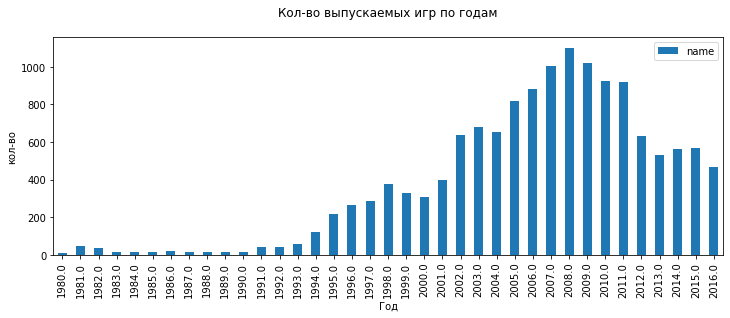

In [22]:
(df
 .pivot_table(columns='year_of_release', values = 'name', aggfunc='count')
 .T
 .plot(kind='bar', figsize=(12,4),  style = 'o-')
)

plt.title('Кол-во выпускаемых игр по годам'+ "\n")
plt.xlabel('Год')
plt.ylabel('кол-во');

График имеет хвост слева, на данных до 2000 года, в принципе, аудитория да и возможности для разработки игр и их продажи были до 2000 года сильно ограничены, поэтому отсечем этот хвост до 2000 года.

In [23]:
df_new = df[df['year_of_release'] >= 2000]
df_new  = df_new.sort_values(by='year_of_release', ascending=False).reset_index()
df_new 

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
1,15839,Mark McMorris Infinite Air,PS4,2016.0,Sports,0.01,0.00,0.00,0.00,49.0,6.0,T,0.01
2,15994,God Eater Off Shot:Shiou-hen Twin Pack & Anima...,PS4,2016.0,Misc,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02
3,15993,God Eater Off Shot: Soma Shikkuzaru-hen Twin P...,PS4,2016.0,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02
4,12400,TrackMania Turbo,XOne,2016.0,Action,0.02,0.04,0.00,0.00,76.0,7.7,E,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12098,1171,Jampack Summer 2K,PS,2000.0,Misc,0.88,0.60,0.00,0.10,NaN,NaN,NaN,1.58
12099,13801,Looney Tunes Duck Dodgers Starring: Daffy Duck,N64,2000.0,Platform,0.03,0.01,0.00,0.00,NaN,NaN,NaN,0.04
12100,12348,Sunrise Eiyuutan R,PS2,2000.0,Role-Playing,0.00,0.00,0.06,0.00,NaN,NaN,NaN,0.06
12101,1977,Dave Mirra Freestyle BMX,PS,2000.0,Sports,0.91,0.11,0.00,0.03,82.0,8.4,E,1.05


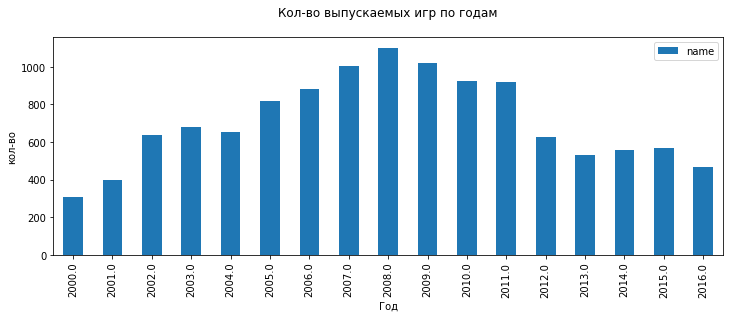

In [24]:
(df_new 
 .pivot_table(columns='year_of_release', values = 'name', aggfunc='count')
 .T
 .plot(kind='bar', figsize=(12,4),  style = 'o-')
)

plt.title('Кол-во выпускаемых игр по годам'+ "\n")
plt.xlabel('Год')
plt.ylabel('кол-во');

Теперь распределние данных выглядит нормально. Отсечением хвоста мы избавились от периодов в которых выпускалось наименьшее количество игр, оставив основные периоды. с 2000 по 2016 год.

### Определение популярных платформ. Определение срока платформ.

Для определение самых популярных платформ необходимо собрать таблицы распеределнные по платформам, и построить графики, на которых будет отражено использование каждой платформы в течение каждого года. Таким образом можно будет определеить топ платформ и за какой срок страые платформы, сменялись новыми.

In [25]:
platforms = df_new.pivot_table(index='platform', columns = 'year_of_release', values = 'sum_sales', aggfunc='sum').fillna(0)
platforms

year_of_release,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
platform,,,,,,,,,,,,,,,,,
3DS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,60.53,51.01,56.32,43.07,27.21,15.10
DC,5.99,1.07,0.29,0.00,0.00,0.00,0.00,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
DS,0.00,0.00,0.00,0.00,17.23,128.68,114.93,121.23,102.44,84.54,61.56,13.48,10.28,0.97,0.00,0.00,0.00
GB,19.76,9.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GBA,0.07,51.32,63.22,50.14,64.05,27.28,4.41,3.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GC,0.00,25.68,48.33,49.85,26.50,25.09,10.01,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
N64,33.97,3.25,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PC,4.66,5.47,8.56,8.84,10.39,4.36,2.81,9.23,12.26,16.33,24.13,34.55,23.22,12.38,13.25,8.49,5.22
PS,86.71,34.32,6.67,2.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


<AxesSubplot:xlabel='year_of_release', ylabel='platform'>

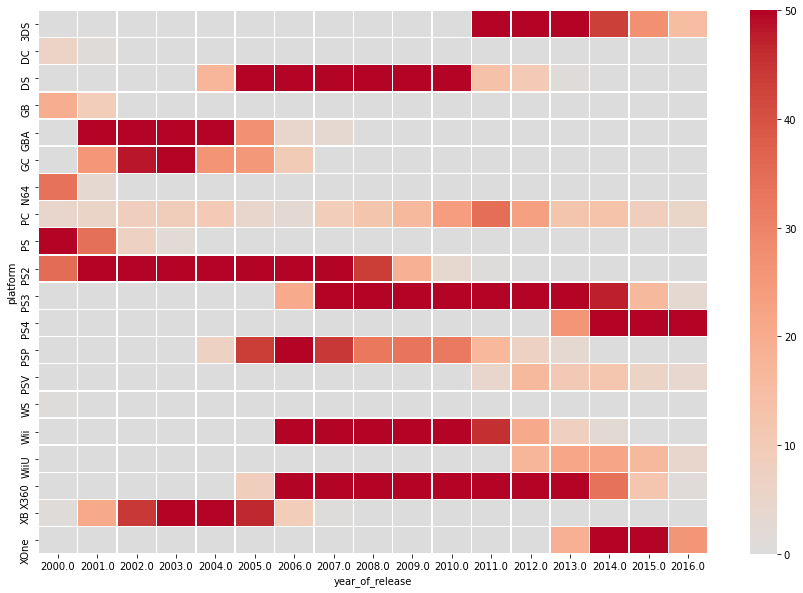

In [26]:
plt.figure(figsize = (15,10))
sns.heatmap(platforms, vmin=0, vmax=50, center= 0, cmap= 'coolwarm', linewidths=.5)

Итак, на хитмэпе видно, что в среднем платформы служат периодами 6-9 лет, затем появляется другая и продажи постепенно падают. Как и на прошлом графике видно что самый популярный период для игр был с 2006 по 2011 год. 
* PC заслуживает внимания за свою устойчивовсть, потому как на протяжении всего периода держался и имел доход, пусть и не такой большой, как у остальных платформ.
* 3DS появился в 2011 года, с 2016 продажи сократились, но все же объемы достаточно велики.
* PS3 к 2016 году уже начал терять свою популярность, из-за появления новой PS4.
* PS4 платформа которая имеет наибольший доход, так же затмила собой остальные версии.
* PSV начала старт в 2011, однако не показала себя выше среднего, но тем не менее продажи на 2016 год, все равно есть.
* WiiU аналогично прошлой, остается на плаву.
* X360 Пришел на смену XB в 2005 году, набрал уверенную популярность, но с выходом XOne, за этот перидод в 8 лет пошел на спад.
* XOne пришел на смену старшему X360, второе место по продажам после PS4.

### Определяем актуальный период. Определяем потенциально прибыльные платформы.

Избавимся от устаревших консолей, оставим лишь те, игры на которые до сих пор покупают, те, что принесут потенциальную прибыль. На основании предыдущих данных возьмем период с 2013 по 2016 год.

In [27]:
df_forecast = df_new[df_new['year_of_release'] >= 2013]
df_forecast = df_forecast.sort_values(by='year_of_release', ascending=False).reset_index(drop=True)
del df_forecast['index']
df_forecast

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
1,Naruto Shippuden: Ultimate Ninja Storm Collection,PS3,2016.0,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
2,Battleborn,XOne,2016.0,Shooter,0.10,0.04,0.00,0.01,71.0,7.2,T,0.15
3,Warhammer: The End Times - Vermintide,PS4,2016.0,Action,0.01,0.02,0.00,0.01,NaN,NaN,NaN,0.04
4,DiRT Rally,PC,2016.0,Racing,0.00,0.03,0.00,0.00,86.0,8.7,E,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...
2120,NHL 14,PS3,2013.0,Sports,0.28,0.17,0.00,0.09,80.0,6.0,E10+,0.54
2121,Army of Two: The Devil's Cartel,PS3,2013.0,Shooter,0.11,0.11,0.01,0.05,58.0,6.7,M,0.28
2122,1/2 Summer +,PSP,2013.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
2123,Battlefield 4,PS3,2013.0,Shooter,1.30,1.42,0.27,0.50,80.0,5.8,M,3.49


Построим график, на котором отразим продажи по платформам за 6 лет.

Text(0, 0.5, 'Прибыль')

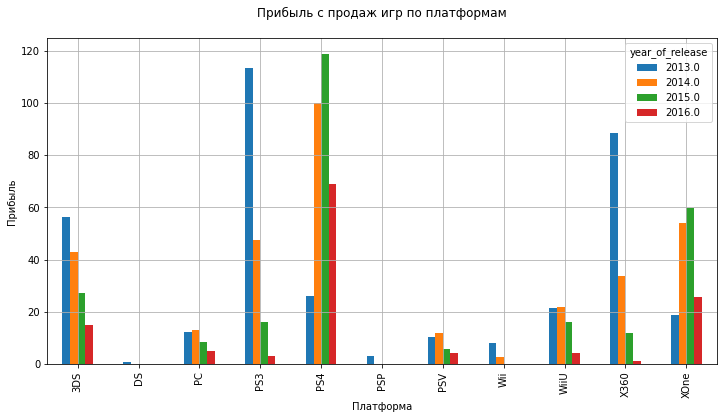

In [28]:
(df_forecast
 .pivot_table(index = 'year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
 .T
 .plot(kind='bar', figsize=(12,6), grid=True)
)

plt.title('Прибыль с продаж игр по платформам'+ "\n")
plt.xlabel('Платформа')
plt.ylabel('Прибыль')

Судя по графики падают продажи по всем платформам, как и было на общем графики по продажам. Но наиболее популярные это:
1. PS4
2. XOne
3. 3DS
4. PC
5. PSV
6. WiiU                                                                                                                    Эти платформы, показывают самую большую прибыль на 2016 год, из-за отрицальной динамики продаж, эти платформы можно считать наиболее устойчивыми к понижениям и потере популярности в 2017 году.

### Диаграмма размаха по платформам

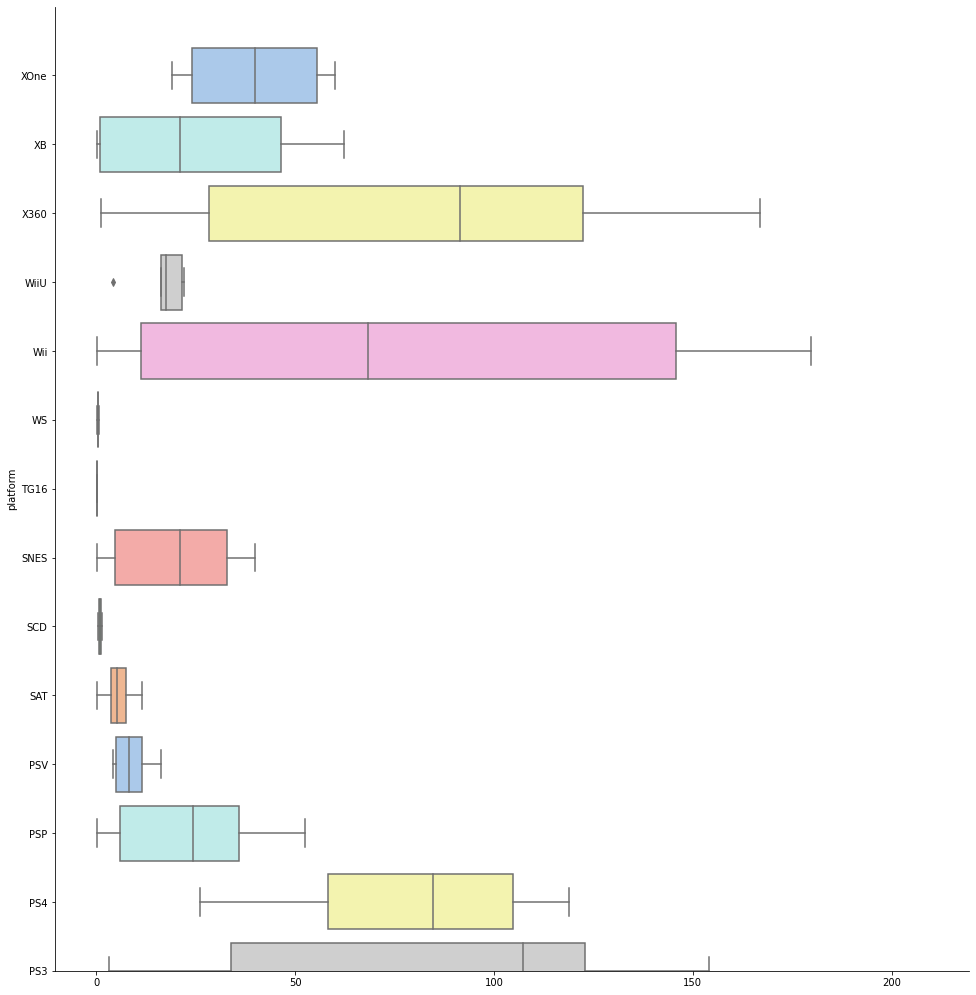

In [67]:
for_box = df.pivot_table(index = 'year_of_release', columns = 'platform', values = 'sum_sales', aggfunc='sum')
g = sns.catplot(kind="box", data= for_box, orient='h', palette = 'pastel')
g.fig.set_figwidth(15)
g.fig.set_figheight(15)
g.set(ylim=(17, 31))

По диаграмме размаха можно определить тип графиков отрицательные или положительные, об этом можно судить по медиане(в каком квартиле она расположена), соответсвенно можно выбрать и платформу в которую лучше всего вкладываться.
Положительная скошенность по платформам:
* GB, NES, PS, PS2, PSP, PSV, Wil, WiiU, XB.
Выбросы были обнаружены:
* 2600, GB, PC, WiiU
XOne показывает нормальное распределение. Остальные графики имеют отрицательную скошенность.

### Зависимость отзывов от продаж

Возьмем одну из популярных платформ - PS4, которая по продажам бьет все современные платформы, посчитаем корреляция и диаграму рассеивания.

0.4064685741971657


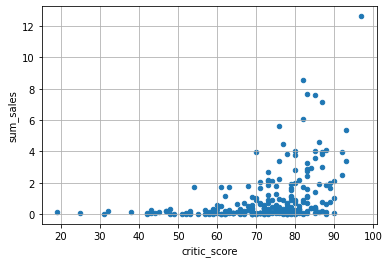

In [30]:
ps4 = df.query('platform == "PS4"')
ps4.plot(x='critic_score', y='sum_sales', kind='scatter', grid=True)
print(ps4['sum_sales'].corr(df['critic_score']))


Значение корреляции Пирсона составило 0,4, значит зависимость от количества продаж и оценки критиков есть, пусть и не очень большая, но это может быть вызвано пропущенными значениями в стобце оценки. То же видно и на диаграмме рассеивания.

В столбце 'user_score' значения типа 'str' и присуетвует по мимо чисел tbd, что означает значения появятся в будущем, но график нельзя будет построить с этим значением, поэтому для этой диаграмы заменим это значение на '0'.

-0.031957110204556376


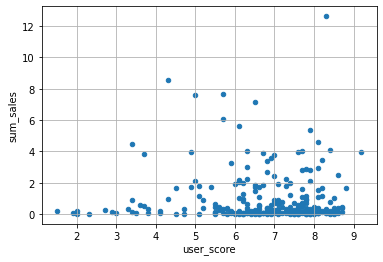

In [31]:
ps4.plot(x='user_score', y='sum_sales', kind='scatter', grid=True)
print(ps4['sum_sales'].corr(ps4['user_score']))

Тут корреляция Пирсона получилась отрицательной и значение очень маленькое, значит зависимости почти нет.

### Соотнесем выводы по остальным платформам

0.3392349287853148
nan
0.1960302829436937
0.33380663565061747
0.4064685741971654
nan
0.2540997021864077
nan
0.3795044989978415


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


0.3503445460228665
0.4121558682031697


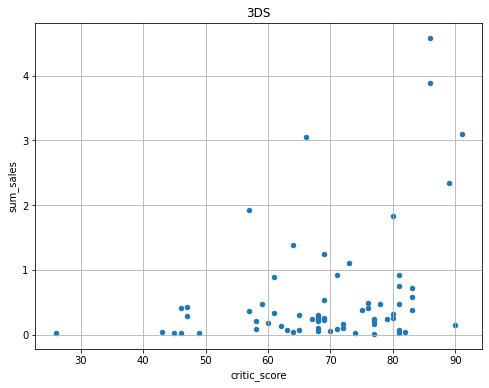

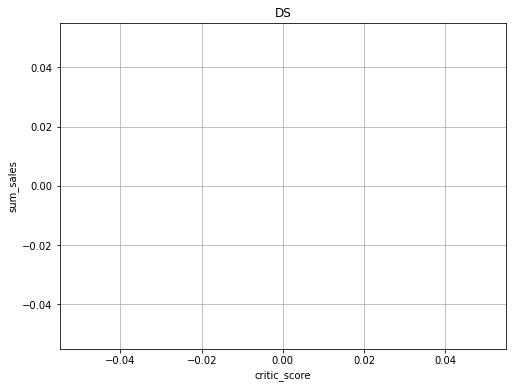

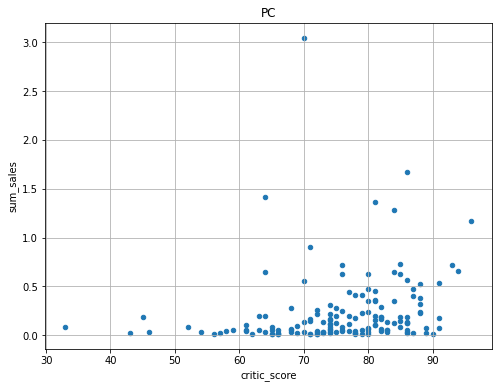

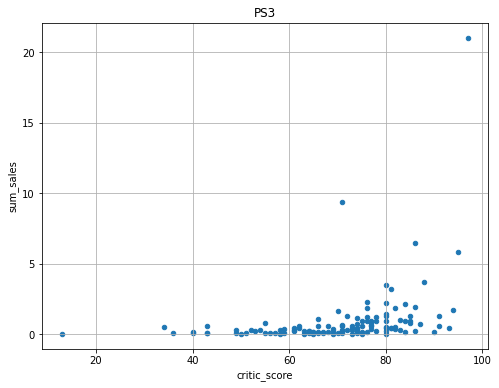

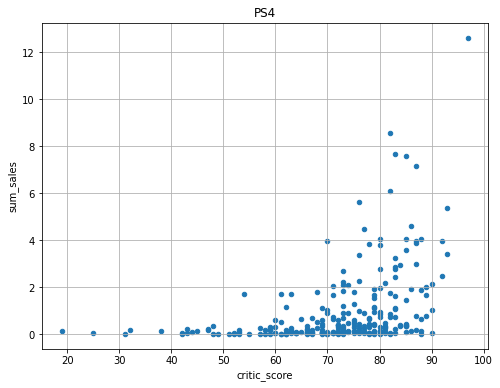

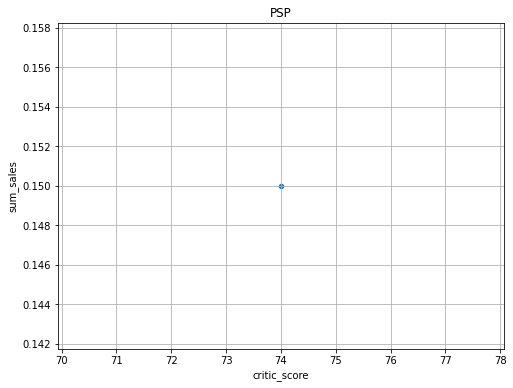

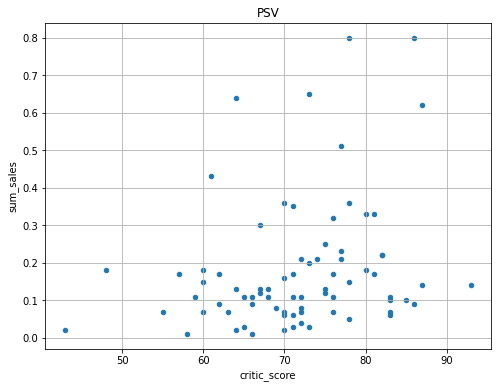

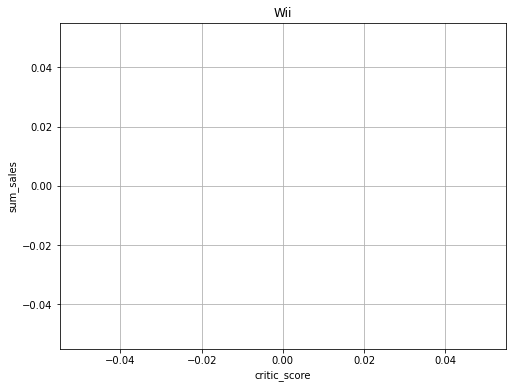

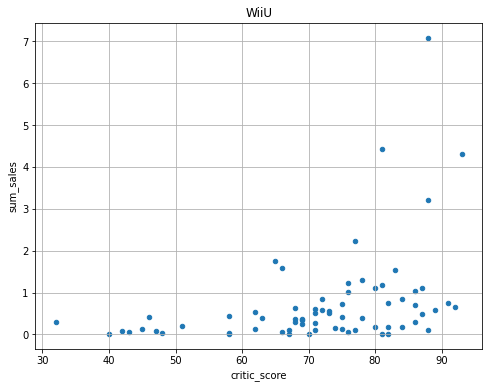

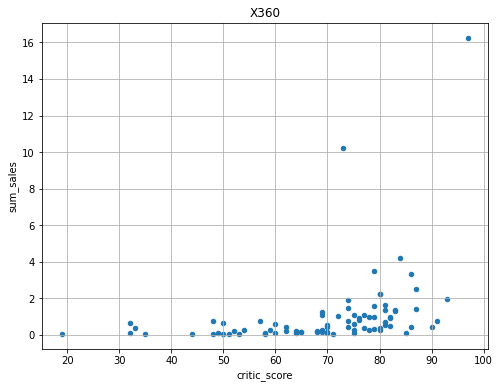

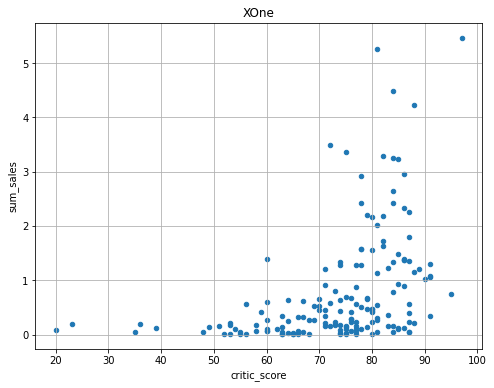

In [32]:
for name, data in df_forecast.groupby('platform'):
    data.plot(title=name, x='critic_score', y = 'sum_sales',kind ='scatter', grid=True, figsize=(8,6)) 
    print(data['sum_sales'].corr(data['critic_score']))

0.3392349287853148
nan
0.1960302829436937
0.33380663565061747
0.4064685741971654
nan
0.2540997021864077
nan
0.3795044989978415
0.3503445460228665
0.4121558682031697


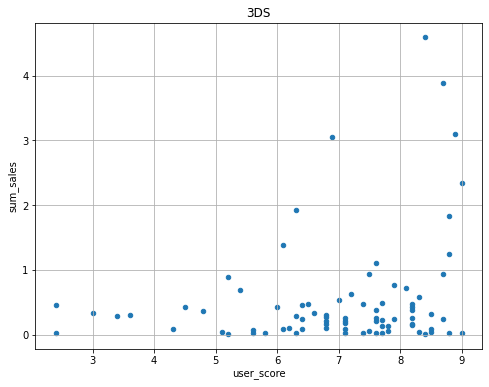

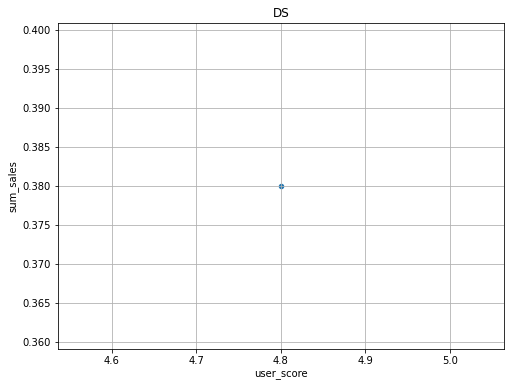

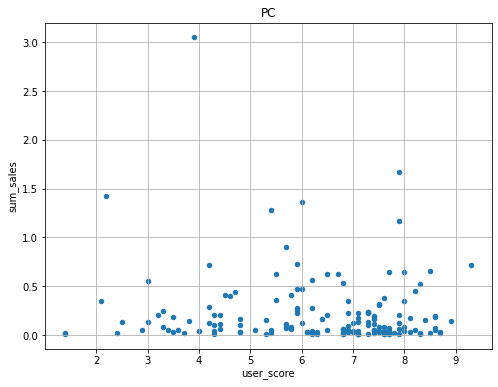

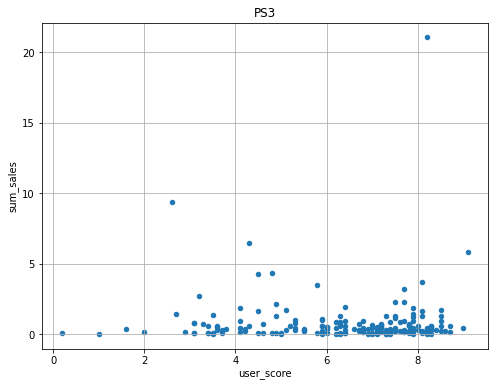

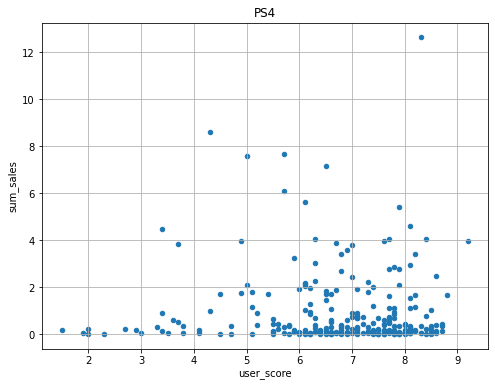

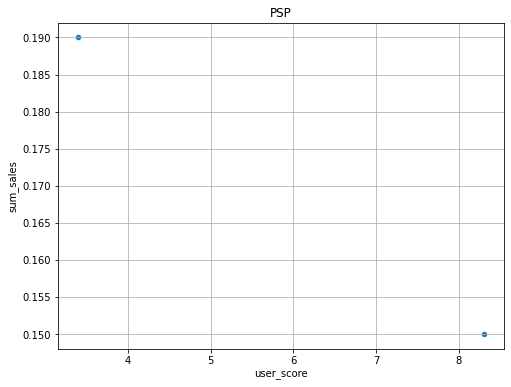

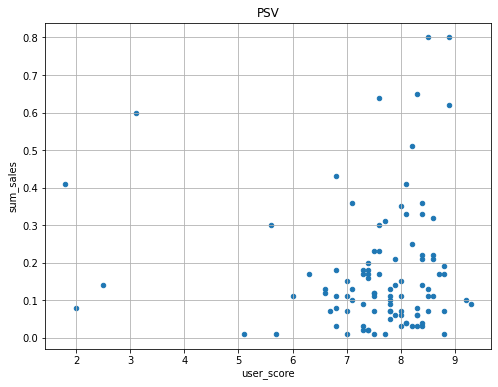

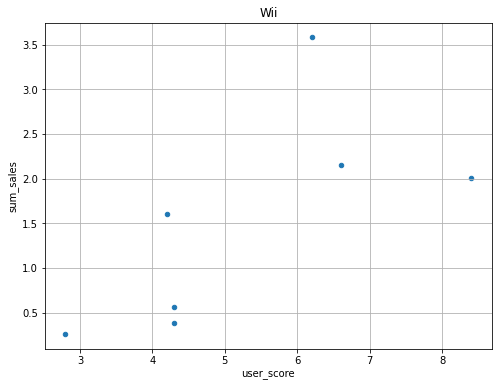

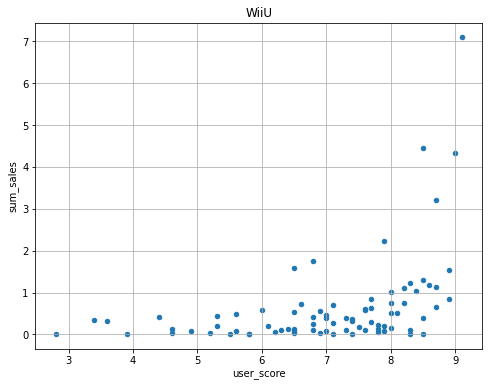

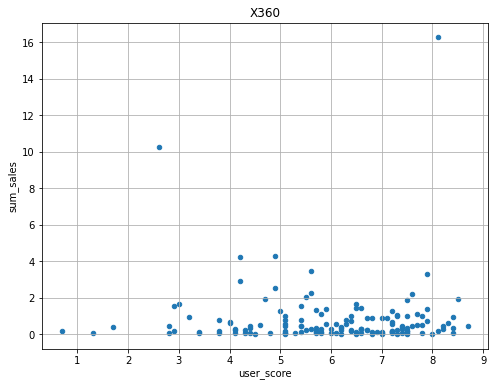

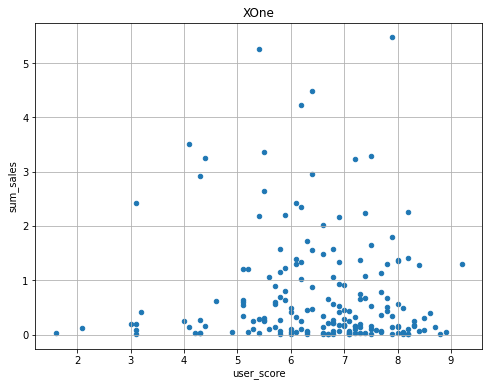

In [33]:
for name, data in df_forecast.groupby('platform'):
     data.plot(title=name, x='user_score', y = 'sum_sales',kind ='scatter', grid=True, figsize=(8,6)) 
     print(data['sum_sales'].corr(data['critic_score']))

Исходя из построенных графиков и посчитанной корреляции, видно, что результаты распределения на диаграмме и корреляции близки к значениям популярной платформы

### Определение прибыльных жанров

Text(0, 0.5, 'Прибыль')

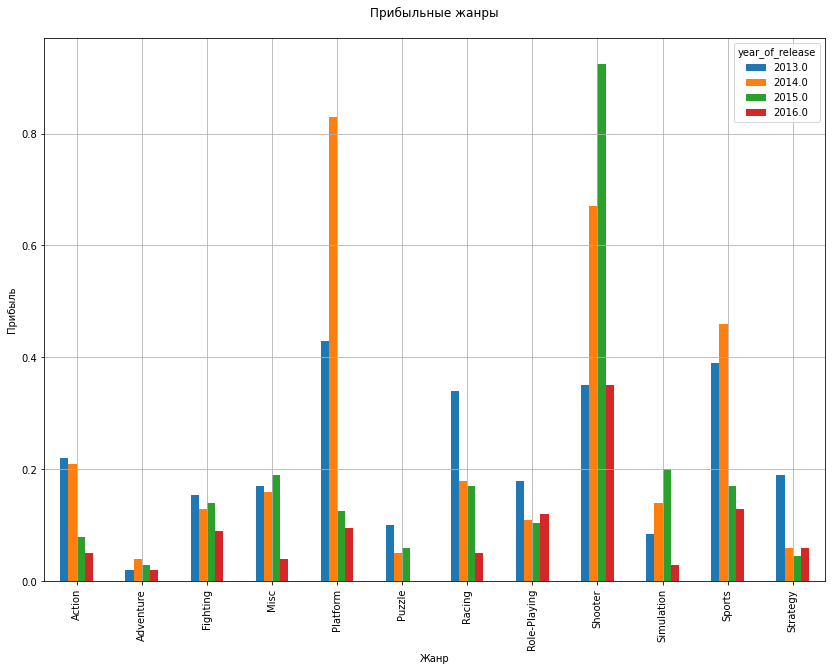

In [34]:
(df_forecast
 .pivot_table(index = 'year_of_release', columns='genre', values='sum_sales', aggfunc='median')
 .T
 .plot(kind='bar', figsize=(14,10), grid=True)
)

plt.title('Прибыльные жанры'+ "\n")
plt.xlabel('Жанр')
plt.ylabel('Прибыль')

Самые прибыльные жанры:
1. Shooter
2. Sports
3. Platform
4. Fighting
5. Action
Видно, что как и продажи по играм, по жанрам тоже упали и наиболее популярными стали shooter и sports, которые меньше всех просели по продажам.

## Портрет пользователя каждого региона

### Портрет пользователей по платформам ТОП-5:

Для того чтобы составить топ 5 плаформ в долях, сгруппируем данные по платформам и продажам в регионах, затем отсортируем данные по убыванию и построим круговую диаграмму по первым пяти значениям.

In [35]:
na_platform = df_forecast.groupby('platform')['na_sales'].sum()
eu_platform = df_forecast.groupby('platform')['eu_sales'].sum()
jp_platform = df_forecast.groupby('platform')['jp_sales'].sum()
na_platform = na_platform.sort_values(ascending = False)
eu_platform = eu_platform.sort_values(ascending = False)
jp_platform = jp_platform.sort_values(ascending = False)
display(na_platform)
display(eu_platform)
display(jp_platform)

platform
PS4     108.62
XOne     92.77
X360     80.90
PS3      63.27
3DS      37.71
WiiU     29.01
PC       11.11
Wii       5.46
PSV       5.03
DS        0.46
PSP       0.00
Name: na_sales, dtype: float64

platform
PS4     141.09
PS3      67.23
XOne     51.43
X360     42.04
3DS      30.11
PC       25.27
WiiU     19.69
PSV       5.95
Wii       4.46
DS        0.43
PSP       0.17
Name: eu_sales, dtype: float64

platform
3DS     67.70
PS3     22.98
PSV     18.48
PS4     15.96
WiiU    10.88
PSP      3.29
X360     0.50
XOne     0.34
Wii      0.05
DS       0.00
PC       0.00
Name: jp_sales, dtype: float64

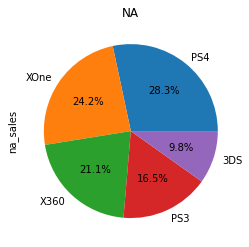

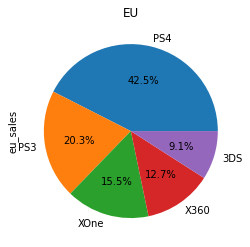

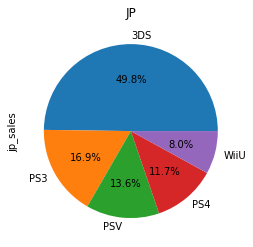

In [36]:
plt.title('NA')
na_platform.head(5).plot(kind='pie', autopct = '%1.1f%%')
plt.show()
plt.title('EU')
eu_platform.head(5).plot(kind='pie', autopct = '%1.1f%%')
plt.show()
plt.title('JP')
jp_platform.head(5).plot(kind='pie', autopct = '%1.1f%%')
plt.show()

Исходя из полученный диаграмм видно, что для Северной Америке и Европы PS4 являтся лидирующей консолью затем XOnе, для Еврпопы аналогичная ситуация с единственной разницей, что XOne только еще начинает набирать популярность, а PS3 потихонку падает. Япония показывает другую динамику 3DS почти 50% и вряд ли в 2017 году будет сильно меньше.

###  Портрет пользователей по жанрам ТОП-5:

In [68]:
na_genre = df_forecast.groupby('genre')['na_sales'].sum()
eu_genre = df_forecast.groupby('genre')['eu_sales'].sum()
jp_genre = df_forecast.groupby('genre')['jp_sales'].sum()
na_genre = na_genre.sort_values(ascending = False)
eu_genre = eu_genre.sort_values(ascending = False)
jp_genre = jp_genre.sort_values(ascending = False)
display(na_genre)
display(eu_genre)
display(jp_genre)

genre
Action          124.66
Shooter         109.61
Sports           65.17
Role-Playing     46.40
Misc             26.64
Platform         17.91
Fighting         15.53
Racing           12.87
Adventure         6.86
Simulation        4.64
Strategy          3.28
Puzzle            0.77
Name: na_sales, dtype: float64

genre
Action          116.44
Shooter          87.72
Sports           60.22
Role-Playing     36.97
Racing           20.09
Misc             19.24
Platform         15.08
Simulation       10.68
Fighting          8.53
Adventure         7.73
Strategy          4.22
Puzzle            0.95
Name: eu_sales, dtype: float64

genre
Role-Playing    51.04
Action          40.02
Misc             9.20
Fighting         7.62
Shooter          6.60
Adventure        5.82
Sports           5.41
Platform         4.79
Simulation       4.46
Racing           2.27
Strategy         1.77
Puzzle           1.18
Name: jp_sales, dtype: float64

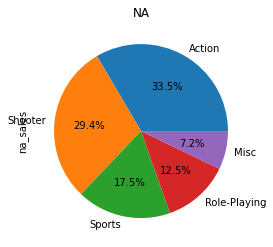

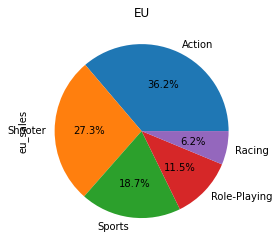

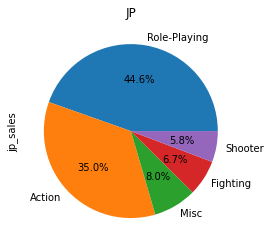

In [69]:
plt.title('NA')
na_genre.head(5).plot(kind='pie', autopct = '%1.1f%%')
plt.show()
plt.title('EU')
eu_genre.head(5).plot(kind='pie', autopct = '%1.1f%%')
plt.show()
plt.title('JP')
jp_genre.head(5).plot(kind='pie', autopct = '%1.1f%%')
plt.show()

На этих графиках видно, что для Северной Америки и Европы топ-5 практически одинаковый. Но для Японии, одними из популярных являются также RP и Action. Значит у Японии своя специфика.

### Оценка влияния в зависимости от возрастной категории.

Для начала разберемся, что такое рейтинг ESRB - это возрастная категория, которая присваивается компьютерной игре, их всего 7:
1. «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет.
2. «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет.
3. «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше».
4. «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет.
5. «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. 
6. «AO» («Adults Only 18+») — «Только для взрослых».

Создадим отдельные таблицы регионов и сгруппируем их по рейтингу и продажам и построим графики, чтобы определить есть зависимость.

<AxesSubplot:xlabel='rating', ylabel='na_sales'>

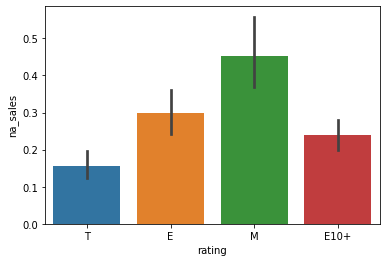

In [39]:
sns.barplot(x='rating', y='na_sales', data=df_forecast)

<AxesSubplot:xlabel='rating', ylabel='eu_sales'>

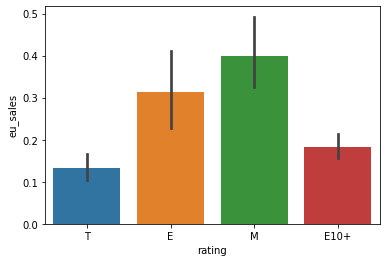

In [40]:
sns.barplot(x='rating', y='eu_sales', data=df_forecast)

<AxesSubplot:xlabel='rating', ylabel='jp_sales'>

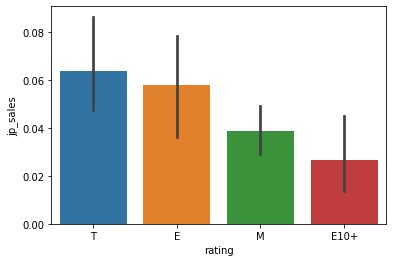

In [41]:
sns.barplot(x='rating', y='jp_sales', data=df_forecast)

Рейтинг 'M' имеет самые высокие значение в Северной Америке и Еврропе, далее идет рейтинг 'E'. Для Японии наиболее популярным является рейтинг 'T', затем так же 'E'. Из чего можно сделать вывод, что лучше всего будет обратиться к этим рейтингам.

## Проверка гипотез

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action  и Sports разные.

### Проверка первой гипотезы

* Н0: Средние пользовательские рейтинги платформ Xbox One и PC равны.
* Н1: Средние пользвовательские рейтинги платформ Xbox One и PC различаются.

In [42]:
XOne = df_forecast[df_forecast['platform'] == 'XOne']['user_score']
PS4 = df_forecast[df_forecast['platform'] == 'PS4']['user_score']
display(XOne)
display(PS4)


2       7.2
12      8.0
20      6.8
26      7.0
30      1.6
       ... 
1936    7.4
1958    5.9
1969    6.2
2056    4.3
2124    3.1
Name: user_score, Length: 236, dtype: float64

3       NaN
7       8.0
8       8.0
14      8.2
19      6.1
       ... 
1996    6.8
2046    7.8
2058    3.7
2076    6.3
2098    6.9
Name: user_score, Length: 386, dtype: float64

In [43]:
alpha = .05

results = st.ttest_ind(XOne, PS4, nan_policy='omit')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.10169342039498884
Не получилось отвергнуть нулевую гипотезу


Посчитаем среднюю разницу в процентах:

In [44]:
print(XOne.mean())
print(PS4.mean())
mean_difference = (PS4.mean() - XOne.mean()) / XOne.mean() * 100
print('Средняя разница в процентах:', mean_difference)

6.521428571428572
6.748249027237354
Средняя разница в процентах: 3.478079278557443


Значение p-value получилось больше чем alpha, соотвественно принимаем нулевую гипотезу, о том, что средние пользовательсие рейтинги по платформам равны. Так же посчитали среднюю разницу в процентах, которая составила 3,5%, значит выборки действительно равны или незначительно различаются.

### Проверка второй гипотезы

* Н0: Средние пользовательские рейтинги жанров Action и Sports не равны.
* Н1: Средние пользовательские рейтинги жанров Action И Sports равны.

In [45]:
action = df_forecast[df_forecast['genre'] == 'Action']['user_score']
sports = df_forecast[df_forecast['genre'] == 'Sports']['user_score']

In [46]:
alpha = .05

results = st.ttest_ind(sports, action, nan_policy='omit')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.0517832389141305e-27
Отвергаем нулевую гипотезу


In [47]:
print(action.mean())
print(sports.mean())
mean_dif = (action.mean() - sports.mean()) / sports.mean() * 100
print('Средняя разница в процентах:', mean_dif)

6.837532133676092
5.238125000000001
Средняя разница в процентах: 30.5339626999373


Значение p-value получилось меньше чем alpha, соотвественно отвергаем нулевую гипотезу и принимаем альтернативную, о том, что средние пользовательсие рейтинги по жанры различаются. Так же посчитали среднюю разницу в процентах, которая составила 30,5%, значит выборки действительно различаются. Рейтинги пользователей по жанру Action выше чем по жанру Sports.

### Пояснения

1. Формулировка гипотез. Основные гипотезы, которые говорят о равенстве рейтингов по платформам и различии рейтингов по жанрам, исходя из этого формулируется нулевая гипотеза, которая была первой, но она может быть и не верна, поэтому выбираем альтернативную, а альтернативная формируется противоположно нулевой.
2. P-value. Это вероятность получить наблюдаемый или еще более далекий от предполагаемого результат при условии, что нулевая гипотеза верна.

## Вывод

1. Были представлены данные о продажах игр по регионам. Данные были изучены, обнаружены пропуски, заменены были те, которые возможно, так же поменены форматы в столбцах 'year_of_release' на целочисленные 'int' и столбце 'user_score' на 'float', так же в столбце 'user_score', заменили значение tbd на nan. Так как это значение означает, что данные появится в будущем, его приняли, как пропуск.
2. Посчитали и добавили в таблицу столбец с суммарными продажами игр по всем регионам.
3. На стадии анализа, с помощью столбчатой диаграммы отсекли хвост за период до 2000 года. Так как по играм в те года, уже беспользно судить о современных играх.
4. При определении самых популярных платформ, мы так же смогли определить пик продаж по играм, это с 2006 по 2011 год, затем продажи начали падать. Самыми популярными платформами оказались:
* PC заслуживает внимания за свою устойчивовсть, потому как на протяжении всего периода держался и имел доход, пусть и не такой большой, как у остальных платформ.
* 3DS 
* PS3 
* PS4
* PSV 
* WiiU 
* X360 
5. С помощью хитмэпа, определи актуальный период для анализа, с 2010 по 2016 год. Также учитывая падение продаж по всем платформам, определили платформы, которые наиболее устойчивы с к этому:
* PS4
* XOne
* 3DS
* PC
* PSV
* WiiU
6. Диаграмма размаха, помогла определить в  каких платформах находятся выбросы и какие имеют скошенность вправо(положительно):
* GB, NES, PS, PS2, PSP, PSV, Wil, WiiU, XB.
Выбросы были обнаружены:
* 2600, GB, PC, WiiU
* XOne показывает нормальное распределение. Остальные графики имеют отрицательную скошенность.
7. Была определена зависимость продаж от отзывов критиков и пользователей, коэффициент Пирсона, который в среднем показал 0,4. Это значит, что зависимость есть, но не большая.
8. Самые прибыльные жанры:
* Action
* Shooter
* RP
* Sports
* Misc
9. Определили портреты пользователей по регионам и выявили топ 5 платформ и топ 5 жанров. 
* За период 2013 - 2016 гг. Для Северной Америки:
1. PS4 - 28,3%
2. XOne - 24,2%
3. X360 - 21,1%
4. PS3 - 16,5%
5. 3DS - 9,8% 
* Для Европы:
1. PS4 - 42,5%
2. PS3 - 20,3%
3. XOne - 15,5%
4. X360 - 12,6%
5. 3DS - 9,1%
* Для Японии:
1. 3DS - 49,8%
2. PS3 - 16,9%
3. PSV - 13,6%
4. PS4 - 11,7%
5. WiiU - 8,0% 
* Жанры по регионам лидирующие Action и Shooter для Северной Америки и Еввропы и RP и Action для Японии.
10. Согласно возрастного рейтинга выделили M и E для Северной Америки и Европы и T и E для Японии.
11. Проверили гипотезы о равенстве средних рейтингов пользователей XOne и PS4, и о неравенстве средних рейтингов пользователей для жанров Action и Sports. Сформулировали нулевую и альтернативныю гипотезы и запутили проверку гипотез с помощью t-теста Cтьюдента. Проверка показала, что:
* Средние рейтинги пользователей для платформ равны или незначительно отличаются.
* Средние рейтинги пользователей по жанрам различаются. 

### Итоговый вывод.

на основании этих расчетов можно сказать, что делая прогноз на 2017 год, наибольшую прибыль смогут принести игры жанра Action, Shooter, Sports, RP и Mics. Платформы на которые следует выпускать такие игры это PS4 и XOne для Европы и Северной Америке и 3DS для Японии. 